In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))
from numpy import array
from numpy import asarray
from numpy import zeros
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [74]:
dataTrain = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project final/Tweets_train.csv")
print(dataTrain.head())
dataValidate = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project final/Tweets_dev.csv")
print(dataValidate.shape)

             tweet_id                                               text  \
0  569179849518161920                    @united you're good. Thank you!   
1  569835751275433984  @AmericanAir way to ruin a vacation, my brothe...   
2  568588936852799488  @JetBlue yes thankfully! Catering just got her...   
3  569525116725567491  @USAirways The automated message isn't helpful...   
4  568807823187976193  @JetBlue I'm #MakingLoveOutofNothingAtAll on m...   

  airline_sentiment  
0          positive  
1          negative  
2          positive  
3          negative  
4          positive  
(1318, 3)


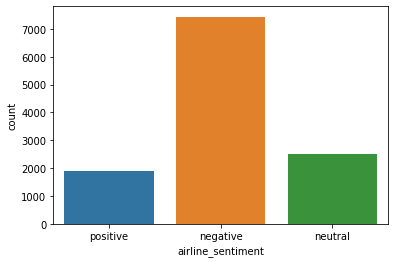

In [75]:
import seaborn as sns
sns.countplot(x='airline_sentiment', data = dataTrain)

In [78]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub(' ',text)

In [79]:
def preprocessing(sentence):
    statement = sentence.lower()
    statement = remove_tags(statement)
    statement = re.sub('[^a-zA-Z]',' ',statement)
    statement = re.sub(r'\s+[a-zA-Z]\s',' ',statement)
    statement = re.sub(r'\s+', ' ', statement)
    #pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    statement = [ps.stem(word) for word in statement if not word in set(stopwords_list)]
    statement = ''.join(statement) 
    return statement

In [80]:
corpus_Train = []
sentences = list(dataTrain['text'])
for x in sentences:
    corpus_Train.append(preprocessing(x))
corpus_Train

[' une u re g hnk u ',
 ' ercnr w  run vcn  brher h clle ll ngh n h ulple plce n lne nl  ge e r n cll bck',
 ' jeblue e hnkfull cerng ju g here n nw he re lng bu ver frure w uppe  be here b ',
 ' urw he ue ege n helpful n  pble  pek wh hun rgh nw eperel nee ur luggge ',
 ' jeblue  knglveufnhngll n  brnlveffr  lx hp c khruf w',
 ' ercnr ju wnle he pp fr phne nce rnk cupn bu nhng  ple geng re  fl ',
 ' une n p lnk  n rcle h verfe he nl cpln wh cen ng he e hng hrr',
 ' jeblue  n ure f u cn  nhng  help e wh h bu f u cn h be gre ',
 ' ercnr  bggge  l  flgh cncelle flghle n ge n ccn n even  nher rlne  le ne free hel ',
 ' urw chrle ff nee prer ppne n repne  hp l f pe ff peple here ',
 ' urw ugge u flure ke huge nn  he u chrle nc  he prve gre cuer ervce  unlke u ',
 ' ercnr plee expln wh  c l he e prce f full runrp fr  nl chnge he eprure e f flgh ',
 ' uhwer  when ur plne en wrk he luxure p fr g w bu u keep  ne nee h bz el ',
 'elee ur ccun jeblue',
 ' vrgnerc hve n nereng flng wh u fer h wll

In [81]:
corpus_Dev = []
sentences = list(dataValidate['text'])
for x in sentences:
    corpus_Dev.append(preprocessing(x))
type(corpus_Dev)

list

In [83]:
sentiment_Train = dataTrain['airline_sentiment']
sentiment_Train = np.array(list(map(lambda x:1 if x== "positive" else (0 if x == "negative" else 2), sentiment_Train)))
print(sentiment_Train)

[1 0 1 ... 0 0 0]


In [84]:
sentiment_validate = dataValidate['airline_sentiment']
sentiment_validate = np.array(list(map(lambda x:1 if x== "positive" else (0 if x == "negative" else 2), sentiment_validate)))
print(sentiment_validate)

[1 1 0 ... 0 0 1]


In [85]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(corpus_Train)
word_tokenizer.fit_on_texts(corpus_Dev)

In [86]:
X_train = word_tokenizer.texts_to_sequences(corpus_Train)
X_dev = word_tokenizer.texts_to_sequences(corpus_Dev)

In [87]:
vocab_length = len(word_tokenizer.word_index) +1
print(vocab_length)

7133


In [88]:
max_len = 1100
X_train = pad_sequences(X_train,padding = 'post', maxlen =max_len)
X_dev = pad_sequences(X_dev,padding = 'post', maxlen =max_len)
print(type(X_train))

<class 'numpy.ndarray'>


In [89]:
embeddings_dictonary = dict()
glove_file = open('/content/drive/MyDrive/Sentiment Analysis Project final/a2_glove.6B.100d.txt',encoding = "utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype ='float32')
    embeddings_dictonary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length,100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictonary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
print(embedding_matrix.shape)


(7133, 100)


In [90]:
snn = Sequential()
embedding_layer = Embedding(vocab_length,100,weights = [embedding_matrix],input_length=max_len, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(1,activation = "sigmoid"))

snn.compile(optimizer= "adam" ,loss = "binary_crossentropy", metrics = ['acc'])
print(snn.summary())

snn_history = snn.fit(X_train,sentiment_Train,batch_size =128,epochs =6,verbose = 1)
print(snn_history)

score = snn.evaluate(X_dev,sentiment_validate,verbose=1)
print("Score is:  ", score[0])
print("Accuracy ", score[1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1100, 100)         713300    
                                                                 
 flatten_5 (Flatten)         (None, 110000)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 110001    
                                                                 
Total params: 823,301
Trainable params: 110,001
Non-trainable params: 713,300
_________________________________________________________________
None
Epoch 1/6
93/93 [==============================] - 4s 37ms/step - loss: 0.5830 - acc: 0.4729
Epoch 2/6
93/93 [==============================] - 3s 36ms/step - loss: 0.4741 - acc: 0.4885
Epoch 3/6
93/93 [==============================] - 3s 36ms/step - loss: 0.4207 - acc: 0.4963
Epoch 4/6
93/93 [=====

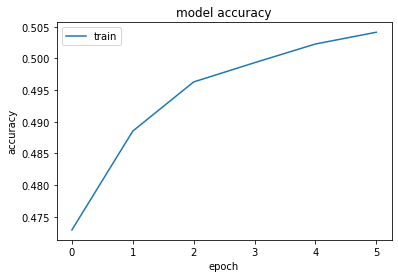

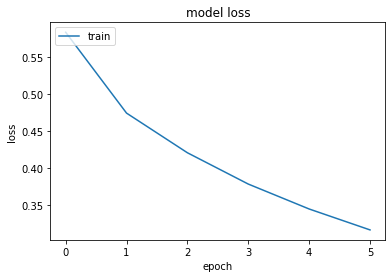

In [97]:
import matplotlib.pyplot as plt

plt.plot(snn_history.history['acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(snn_history.history['loss'])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [98]:
dataTest = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project final/New_Tweets_test-1.csv")

In [99]:
unseen_reviews = dataTest['text']

unseen_processed = []
for review in unseen_reviews:
    unseen_processed.append(preprocessing(review))
unseen_processed

[' ercnr nee refun ',
 ' urw fer cncelle flghln n el cung e   cnnecng flgh nher ngh n beng he hnk phec',
 ' jeblue hnk  uch cn w  fl wh u gu ',
 ' une hve never been re frure hn  cnvern wh une wh cn pek pnh  he curer cpn h h  bg ',
 ' urw he wr hl e crz gen hrrble n ccunbl uruck',
 ' ercnr  pleure nex  flgh h wene  ln l fr exhbn ee u hen ',
 ' une frnkl wre cuer ervce ever prble wll hppen hw u el efne cpn never gn une ',
 ' uhwer u nee  ge ur c geher u new h rnng  ur plne w lfuncnng e ve been ele e ',
 ' ercnr n he cncelle flghe  flgh n lef e wh n help  fn hel   n lep n n rpr fr ngh ',
 ' jeblue flgh fr b  p keff n le flgh',
 ' une  r xweekl flgh fr newrlen  cncun n beween  ep vgeek',
 ' jeblue rw hr nere wn n jnur jblu leekne hp c znujp bv',
 ' ercnr e becue  gh n be  urgen fr u bu  rell  fr e ',
 ' urw nw n hl fr hr n h  rculu',
 ' uhwer wh  he u n flgh l u ',
 ' urw bu u gu wche e n n nfr e f he chhe',
 ' jeblue ell e p p cnfre flgh wll nw c e ch nl rpr hur befre  flgh rpff nuppr',


In [100]:
sentiment_Test = dataTest['airline_sentiment']
sentiment_Test = np.array(list(map(lambda x:1 if x== "positive" else (0 if x == "negative" else 2), sentiment_Test)))
print(type(sentiment_Test))

<class 'numpy.ndarray'>


In [101]:
word_tokenizer.fit_on_texts(unseen_processed)
X_test = word_tokenizer.texts_to_sequences(unseen_processed)
X_test

[[12, 61, 190],
 [11, 74, 36, 327, 1, 37, 802, 4, 298, 7, 123, 96, 1, 152, 2, 20, 678],
 [17, 20, 111, 24, 13, 49, 9, 3, 82],
 [8,
  26,
  102,
  45,
  15,
  338,
  98,
  1184,
  9,
  8,
  9,
  24,
  249,
  1458,
  2,
  2007,
  222,
  6,
  6,
  46],
 [11, 2, 86, 57, 4, 532, 80, 311, 1, 1390, 1794],
 [12, 1364, 139, 7, 6, 769, 243, 23, 5, 3428, 78, 3, 93],
 [8, 2223, 247, 40, 38, 91, 108, 50, 301, 52, 3, 37, 1129, 222, 102, 79, 8],
 [16,
  3,
  61,
  18,
  14,
  22,
  352,
  3,
  110,
  6,
  160,
  14,
  55,
  13,
  2293,
  4,
  58,
  45,
  59,
  4],
 [12,
  1,
  2,
  36,
  145,
  7,
  1,
  174,
  4,
  9,
  1,
  44,
  165,
  159,
  1,
  1316,
  1,
  1,
  87,
  5,
  96],
 [17, 7, 5, 43, 25, 671, 1, 31, 7],
 [8, 29, 2184, 7, 5, 2393, 1071, 1, 434, 182, 717],
 [17, 155, 64, 980, 48, 1, 1227, 860, 2420, 32, 22, 3429, 1217],
 [12, 4, 109, 246, 1, 27, 2093, 5, 3, 19, 112, 5, 4],
 [11, 35, 1, 57, 5, 64, 1, 6, 294],
 [16, 9, 2, 3, 1, 7, 23, 3],
 [11, 19, 3, 82, 575, 4, 1, 1, 1261, 4, 10, 2, 343

In [102]:
X_test = pad_sequences(X_test,padding = 'post', maxlen =max_len)
X_test

array([[ 12,  61, 190, ...,   0,   0,   0],
       [ 11,  74,  36, ...,   0,   0,   0],
       [ 17,  20, 111, ...,   0,   0,   0],
       ...,
       [ 16,  39,   6, ...,   0,   0,   0],
       [ 12,   9, 333, ...,   0,   0,   0],
       [ 12,  52,  24, ...,   0,   0,   0]], dtype=int32)

In [103]:
sentiment_Test = snn.predict(X_test)
X_test

46/46 [==============================] - 0s 10ms/step


array([[ 12,  61, 190, ...,   0,   0,   0],
       [ 11,  74,  36, ...,   0,   0,   0],
       [ 17,  20, 111, ...,   0,   0,   0],
       ...,
       [ 16,  39,   6, ...,   0,   0,   0],
       [ 12,   9, 333, ...,   0,   0,   0],
       [ 12,  52,  24, ...,   0,   0,   0]], dtype=int32)

In [106]:
sentiment_Test = np.array(list(map(lambda x:"positive" if x== "1" else ("negative" if x == 0 else "neutral"), sentiment_Test)))


<ipython-input-106-a393c762552f>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sentiment_Test = np.array(list(map(lambda x:"positive" if x== "1" else ("negative" if x == 0 else "neutral"), sentiment_Test)))


In [107]:
dataTest['Predicted airline_sentiment'] = sentiment_Test

df_prediction_sentiments = pd.DataFrame(dataTest['Predicted airline_sentiment'], columns = ['Predicted airline_sentiment'])
df_tweetid                 = pd.DataFrame(dataTest['tweet_id'], columns = ['tweet_id'])
df_text           = pd.DataFrame(dataTest['text'], columns = ['text'])
df_airline_sentiment           = pd.DataFrame(dataTest['airline_sentiment'], columns = ['airline_sentiment'])


dfx=pd.concat([df_tweetid, df_text,df_airline_sentiment, df_prediction_sentiments],axis =1)

dfx.head(5)

,tweet_id,text,airline_sentiment,Predicted airline_sentiment
0,570252000000000000,@AmericanAir I need refund.,negative,neutral
1,568173000000000000,@USAirways after 3 Cancelled Flightlations and...,negative,neutral
2,569321000000000000,@JetBlue thanks so much. Can't wait to fly wit...,positive,neutral
3,569503000000000000,@united I have never been more frustrated than...,negative,neutral
4,568981000000000000,"@USAirways - the worst! Hold time crazy, agent...",negative,neutral


'n'